In [1]:
import pandas as pd
import numpy as np
import sys



import seaborn
from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from tslearn.clustering import silhouette_score


In [3]:
import sklearn

print(sklearn.__version__)

1.0.2


In [248]:
def cleaningFactorNames(factorDf):
    
    """
    Given an input DataFrame containing Risk Factors 
    : param factorDf DataFrame
    return : list containing processed factor names
    
    """
    
    cNames = []
    
    for col in factorDf.columns:
        cnames= cNames.append(col.replace("|","_"))
    
    return cNames

In [249]:
def remove_series_mostly_na(df, min_percentage):
    '''
    This function removes from the input df all series having more than an input percentage of NA values.
    
    Arguments:
        df: input dataframe with dates as index and time series names as columns
        min_percentage: minimum percentage of non NA values to keep a series in the dataframe
        
    Returns:
        df_return: input df without the series not having at least min_percentage non NA observations
    '''
    
    l = []
    for c in df.columns:
        idx_max = df.loc[df[c].notna() == True].index.max()
        idx_min = df.loc[df[c].notna() == True].index.min()
        nr_days = df.loc[df[c].notna() == True].shape[0]
        tpl = (c,idx_min,idx_max,nr_days)
        l.append(tpl)
        
    df_times = pd.DataFrame(l)
    df_times.columns = ['CurveID','start_date','end_date','notnull_days']
    df_times['delta_days'] = df_times['end_date'] - df_times['start_date']
    df_times['perc_complete'] = df_times['notnull_days'] / df.shape[0]
    lb_time = df_times.loc[df_times['perc_complete'] >= min_percentage,'start_date'].max()
    ub_time = df_times.loc[df_times['perc_complete'] >= min_percentage,'end_date'].min()
    print("Maximum Timestamp of available data point " + str(lb_time))
    print("Minimum Timestamp of not null data point cross time series " + str(ub_time))

    lst_cols = df_times.loc[df_times['perc_complete'] >= min_percentage,'CurveID'].unique()
    df_return = df[lst_cols].loc[(df.index >= lb_time) & (df.index <= ub_time)].\
        fillna(method='bfill', inplace=False)
               
    return df_return

In [250]:
def import_data_clustering_issuer_rf(issuer_curves_file_name='Sprd_5Y_Gesav_import_Sector_values.csv',
                                    sep_issuer_curves_file=',',
                                    fx_rf_file_name='Observations - UniverseFX.csv',
                                    local_rf_file_name='Observations - UniverseLOCAL.csv',
                                    sep_rf_file=',',
                                    local_rf_to_include=None,
                                    fx_rf_to_include=None,
                                    all_rf_to_include=None):
    '''
    This function reads all input data needed for clustering of issuer curves based on links with risk factors.
    
    Arguments:
        issuer_curves_file_name: name of the .csv file with spread of issuer curves
        sep_issuer_curves_file: separator used in the file with spread data
        fx_rf_file_name: name of the .csv file with values of the foreign exchange risk factors
        local_rf_file_name: name of the .csv file with values of the local risk factors
        sep_rf_file: separator used in the files with info about risk factors
        local_rf_to_include: name of the .csv file with the list of local risk factors to include in the analysis (the file must contain only one column)
        fx_rf_to_include: name of the .csv file with the list of fx risk factors to include in the analysis (the file must contain only one column)
        all_rf_to_include: name of the .csv file with the list of all risk factors to include in the analysis (the file must contain only one column)
        
    Returns:
        df_all: df with issuer curves spread values
        df_all_lookup:: df_all after pivot operations to have dates as index and issuer names as columns
        obs_universe_fx: df with info about fx risk factors, with dates as index and risk factors names as columns
        obs_universe_local: df with info about local risk factors, with dates as index and risk factors names as columns
        risk_factors_to_include: list of risk factors to include in the analysis
        
    '''
    
    
    # Read input dataset
    df_all = pd.read_csv('Data/' + issuer_curves_file_name, sep = sep_issuer_curves_file)

    # Pivot input dataset
    df_all['Date'] = pd.to_datetime(df_all['Date'])
    df_all.head()

    df_all_lookup = df_all.pivot_table( index='Date',columns = "CurveID", values ="Sprd").iloc[:,:].sort_index(ascending=True,inplace=False)
    df_all_lookup.head()
    
    # Read files about risk factors
    obs_universe_fx = pd.read_csv('Data/Observations - UniverseFX.csv', sep=sep_rf_file, thousands=',')
    obs_universe_local = pd.read_csv('Data/Observations - UniverseLOCAL.csv', sep=sep_rf_file, thousands=',')
    obs_universe_local.columns = [col.replace('\\','_').replace("|","_").replace("(SP)","#").replace("(NS)","~").split("(")[0].replace("#","(SP)").replace("~","(NS)").rstrip() for col in obs_universe_local.columns]
    obs_universe_fx.columns = [col.replace('\\','_').replace("|","_").replace("(SP)","#").replace("(NS)","~").split("(")[0].replace("#","(SP)").replace("~","(NS)").rstrip() for col in obs_universe_fx.columns]
    obs_universe_fx['Date[Date]'] = pd.to_datetime(obs_universe_fx['Date[Date]'])
    obs_universe_local['Date[Date]'] = pd.to_datetime(obs_universe_local['Date[Date]'])

    obs_universe_fx = obs_universe_fx.set_index('Date[Date]', drop=True).drop(columns='level')
    obs_universe_local = obs_universe_local.set_index('Date[Date]', drop=True).drop(columns='level')
    
    if all_rf_to_include is None:
        if local_rf_to_include is None:
            local_risk_factors_to_include = []
        else:
            local_risk_factors_to_include = list(pd.read_csv('Data/' + local_rf_to_include).iloc[:, 0])
            local_risk_factors_to_include = [elem.replace('\\','_') for elem in local_risk_factors_to_include]
            
        if fx_rf_to_include is None:
            fx_risk_factors_to_include = []
        else:
            fx_risk_factors_to_include = list(pd.read_csv('Data/' + fx_rf_to_include).iloc[:, 0])
            fx_risk_factors_to_include = [elem.replace('\\','_') for elem in fx_risk_factors_to_include]
        risk_factors_to_include = [*local_risk_factors_to_include, *fx_risk_factors_to_include]
    
    else:
        risk_factors_to_include = list(pd.read_csv('Data/RiskFactor_top_per_type.csv').iloc[:, 0])
        risk_factors_to_include = [elem.replace('\\','_') for elem in risk_factors_to_include]
    
    
    return df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include

In [251]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import check_random_state
from scipy.linalg import block_diag
import matplotlib.pylab as plt
import matplotlib



def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    dist_matrix = ((1-corr0.fillna(0))/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):

        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")
    
    newIdx = np.argsort(kmeans.labels_)


    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)
    
    return corr1, clstrs, silh_coef_optimal
    

#Top level of clustering
''' Improve number clusters using silh scores
    :param corr_mat: (pd.DataFrame) Correlation matrix
    :param clusters: (dict) Clusters elements
    :param top_clusters: (dict) Improved clusters elements
    :return: (tuple) [ordered correlation matrix, clusters, silh scores]
'''
def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    
    dist = ((1 - corr0.fillna(0)) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    
    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)
    
    return corrNew, clstrsNew, silhNew


def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1
        
    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = sum(clusterTstats.values())/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()]) 
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else: 
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat
             

def getCovSub(nObs, nCols, sigma, random_state=None):
    #sub correl matrix
    rng = check_random_state(random_state)
    if nCols == 1:
        return np.ones((1,1))
    ar0 = rng.normal(size=(nObs, 1)) #array of normal rv
    ar0 = np.repeat(ar0, nCols, axis=1) #matrix of columns repeating rv. Simulate time-series of at least 100 elements.
    ar0 += rng.normal(loc=0, scale=sigma, size=ar0.shape) #add two rv X~Y~N(0,1), Z=X+Y~N(0+0, 1+1)=N(0,2)
    ar0 = np.cov(ar0, rowvar=False) #ar0.shape = nCols x nCols
    return ar0

#generate a block random correlation matrix
#
# The last block in the matrix is going to be as large as possible
# Controlling the size of the last block matrix can be done by inceasing minBlockSize
# 
# parts is the size of the blocks. If nCols, nBlocks, minBlockSize = 6,3,1
# then parts = [1,1,4] resulting in 1x1, 1x1, 4x4 block-covariance-matrixes
# If block > 1x1 matrix the diagonal is 2 or 2*sigma as the variance of
# covariance from getCovSub() is Z=X+Y => 2*sigma
def getRndBlockCov(nCols, nBlocks, minBlockSize=1, sigma=1., random_state=None):
    
    print("getRndBlockCov:"+str(minBlockSize))
    rng = check_random_state(random_state)
    parts = rng.choice(range(1, nCols-(minBlockSize-1)*nBlocks), nBlocks-1, replace=False)
    parts.sort()
    parts = np.append(parts, nCols-(minBlockSize-1)*nBlocks) #add nCols to list of parts, unless minBlockSize>1
    parts = np.append(parts[0], np.diff(parts))-1+minBlockSize
    print("block sizes:"+str(parts))
    cov=None
    for nCols_ in parts:
        cov_ = getCovSub(int(max(nCols_*(nCols_+1)/2., 100)), nCols_, sigma, random_state=rng)
        if cov is None:
            cov = cov_.copy()
        else: 
            cov = block_diag(cov, cov_) #list of square matrix on larger matrix on the diagonal
    
    return cov

# add two random covariance matrixes and return the correlation matrix as a dataframe. 
#
# The first covariance matrix consists of nBlocks
# and the second matrix consists of 1 block - which adds noice.
# Note: noice is also added in each block matrix. Why is noice added 2 times?
def randomBlockCorr(nCols, nBlocks, random_state=None, minBlockSize=1):
    #Form block corr
    rng = check_random_state(random_state)
    
    print("randomBlockCorr:"+str(minBlockSize))
    cov0 = getRndBlockCov(nCols, nBlocks, minBlockSize=minBlockSize, sigma=.5, random_state=rng)
    cov1 = getRndBlockCov(nCols, 1, minBlockSize=minBlockSize, sigma=1., random_state=rng) #add noise
    cov0 += cov1
    corr0 = cov2corr(cov0)
    corr0 = pd.DataFrame(corr0)
    return corr0

In [252]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist,pdist
def compute_ts_correlation(df, detrend_strategy='diff', res_index=None, res_columns=None, return_distance=False):
    '''
    This function computes correlation between time series in a dataframe.
    
    Arguments:
        df: input dataframe with shape (n_timestamp, n_series)
        detrend_strategy: strategy to remove trend from series, current options are 'diff' for first-order differences, 'perc_change' for percentage change and None for no detrend. Default = 'diff'
        res_index: list of columns from df to appear in the index of the resulting df. Default = None, take all columns from df
        res_columns: list of columns from df to appear in the columns of the resulting df. Default = None, take all columns from df
        return_distance: if True, correlation-based distance is computed. Otherwise, linear correlation is computed. Default=False
     Returns:
         df with shape (len(res_index), len(res_columns)) with correlation between time series
    '''
    
    if res_index is None:
        res_index = df.columns
        
    if res_columns is None:
        res_columns = df.columns
    
    if detrend_strategy == 'perc_change':
        df_changed = df.pct_change()
    elif detrend_strategy == 'diff':
        df_changed = df.diff()
    else:
        df_changed = df
        
    if not return_distance:
        df_correlations = df_changed.corr().loc[res_index, res_columns]
    else:
        mat_1 = df.loc[:, res_index].T
        mat_2 = df.loc[:, res_columns].T
        df_correlations = pd.DataFrame(cdist(mat_1, mat_2, metric='correlation'), index=res_index, columns=res_columns)

    
    return df_correlations

In [253]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

def try_k_means_varying_k(df, use_ts_kmeans=False, metric_distance='euclidean', min_num_clusters=3, max_num_clusters=50, n_init=5):
    '''
    This function runs K-Means clustering on input data with different values of number of clusters and returns clustering results, silhouette and inertia of the all the clustering tests.
    
    Arguments:
        df: input df with shape (n_series, n_dim)
        use_ts_kmeans: specify whether using TimeSeriesKmeans from tslearn (True) or KMeans from sklearn (False). Default=False
        metric_distance: if use_ts_kmeans=True, distance metric to be used in the clustering algorithm. Default='euclidean'
        min_num_clusters: minimum number of clusters for the experiments. Default=3
        max_num_clusters: maximum number of clusters fot the experiments. Default=50
        n_init: number of different centroid inizialization in KMeans algorithm. Default=5
        
    Returns:
        km_results: dictionary with the assigned label per each number of clusters
        silhoutte_scores: dictionary with silhouette score per each number of clusters
        inertia_info: dictionary with inertia per each number of cluster
    '''    
        
    inertias_info = {}
    silhouette_scores = {}
    km_result = {}
    
    for k in np.arange(min_num_clusters, max_num_clusters + 1, 1):
        
        if not use_ts_kmeans:
            km_fit = KMeans(n_clusters=k, max_iter=50, random_state=0, n_init=n_init).fit(df)
        else:
            km_fit = TimeSeriesKMeans(n_clusters=k, metric=metric_distance, max_iter=50, random_state=0, n_init=n_init,
                                      max_iter_barycenter=10).fit(df)
        km_labels = km_fit.labels_
        sil_score = silhouette_score(df, km_labels, metric=metric_distance)
        inertias_info[k] = km_fit.inertia_
        silhouette_scores[k] = sil_score
        km_result[k] = km_labels
        
    return km_result, silhouette_scores, inertias_info

In [254]:
def plot_kpi_by_num_clusters(kpi_info, kpi_name):
    '''
    This function builds plot with values of input kpi for clustering results with different numbers of clusters.
    
    Arguments:
        kpi_info: dictionary with number of cluster as key and value of kpi as values
        kpi_name: name of the kpi included in the kpi_info
    
    Returns:
        No return value, chart is shown.
    '''
    
    fig = plt.figure()
    k_max = max(kpi_info.keys())

    ax1 = fig.add_subplot(111)
    ax1.plot(range(3, k_max + 1), kpi_info.values(), '-*')
    plt.xlabel('Number of clusters')
    plt.ylabel(kpi_name)
    plt.xticks(range(3, k_max + 1))
    plt.grid()

    fig.tight_layout()
    fig.set_size_inches(18.5,10.5)

    plt.show()

In [255]:
def silhouette_plot(X, cluster_labels, metric_for_siluette='euclidean'):
    '''
    This function builds silhouette plot for the given data and cluster labels.
    
    Arguments:
        X: input data matrix with shape (n_samples, n_features)
        cluster_labels: array with cluster labels assigned to samples in X
        metric_for_silhouette: metric to be used for silhouette score computation. Default='euclidean'
        
    Returns:
        No return value, chart is shown.
    '''

    n_clusters = len(set(cluster_labels))
    print('Number of clusters for silhouette plot: ' + str(n_clusters))
    
    distinct_labels = np.sort(list(set(cluster_labels)))
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([min(sample_silhouette_values), 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    silhouette_avg = silhouette_score(X, cluster_labels, metric=metric_for_siluette)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        curr_label = distinct_labels[i]
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == curr_label]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(curr_label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [256]:
def hierarchical_clustering_and_dendrogram(df, linkage_hierarchical_clustering='ward',
                                          num_clusters=2, distance_linkage_threshold=None):
    '''
    This function fit Hierarchical Clustering on input dataframe, plots dendrogram and returns fitted clustering object.
    
    Arguments:
        df: input df with shape (n_samples, n_dim)
        linkage_hierarchical_clustering: type of linkage to be used in Hierarchical Clustering. Default='ward'
        num_clusters: number of clusters to form as well as the number of centroids to generate. Default=2
        distance_linkage_threshold: linkage distance threshold above which, clusters will not be merged. Default=None
        
    Returns:
        clf: AgglomerativeClustering object fitted on input data
        Z: linkage matrix
    '''
    
    clf = AgglomerativeClustering(n_clusters=num_clusters, distance_threshold=distance_linkage_threshold,
                                  linkage=linkage_hierarchical_clustering, compute_distances=True, compute_full_tree=True)
    clf.fit_predict(df)
    
    plt.figure(figsize = (18,10))
    plt.title('Hierarchical Clustering Dendrogram')
    Z = plot_dendrogram(clf, p=10, color_threshold = 110)
    plt.show()
    
    return clf, Z

In [257]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    '''
    This function plots dendrogram from fitted AgglomerativeClustering model.
    
    Arguments:
        model: fitted AgglomerativeClustering object
        **kwargs: arguments for function dendrogram in module scipy.cluster.hierarchy 
        
    Returns:
        linkage_matrix: linkage matrix representing the defined dendrogram
    '''
        
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix    

In [258]:
def compute_inertia(df, clustering_results):
    '''
    This function computes inertia for a given clustering assignment of observations in the input df.
    Inertia is defined as the average squared distance of observations from their closest cluster center.
    
    Arguments:
        df: input df with shape (n_samples, n_features)
        clustering_results: array with cluster labels per each sample
        
    Returns:
        inertia:  value of inertia for the given clustering assignment
        barycenters: df with coordinates of barycenter of each cluster 
    '''
    
    temp = df.assign(cluster_label=clustering_results)
    barycenters = temp.groupby('cluster_label').mean()
    temp['dist_from_bar'] = temp.apply(lambda x: np.sum((x - barycenters.loc[x['cluster_label']])**2), axis=1)
    inertia = np.mean(temp['dist_from_bar'])
    
    return inertia, barycenters 

In [259]:
import numpy as np
import numpy.linalg as la 
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from scipy.optimize import minimize
from scipy.linalg import block_diag
from scipy.spatial.distance import correlation
import scipy.stats as ss

from sklearn.covariance import LedoitWolf, ShrunkCovariance, EmpiricalCovariance
from sklearn.metrics import mutual_info_score
from sklearn.neighbors import KernelDensity

def mpPDF(var, q, pts):
    """
    compute Theoretical Marchenko-Pastur distribution 
    """
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 
    eVal = np.linspace(eMin, eMax, pts) 
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def getPCA(matrix):
    """
    Get Eigenvalues and Eigenvectors from hermitian matrix
    """
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec
    
def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    """
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    if x is None: x = np.unique(obs).reshape(-1,1)
        
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf


# Add signal to a Random Covariance Matrix
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
# Fitting the Marchenko Pastur PDF
# Find Sum of Squared Errors
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# Find max random eVal by fitting Marcenko-Pastur Distribution 
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

# Constant Residual Eigenvalue Method

# Remove noise from Correlation Matrix by fixing Random Eigenvalue
# Operation invariante to trace(Correlation)
# The Trace of a square matrix is the _Sum_ of its eigenvalues
# The Determinant of the matrix is the _Product_ of its eigenvalues
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1
    

# This method assumes a sorted set of eigenvalues and eigenvectors.
# The market component is the first eigenvector with highest eigenvalue.
# it returns singular correlation matrix: 
# the detoned correlation matrix is singular, as a result of eliminating (at least) one eigenvector."
def detoned_corr(corr, eigenvalues, eigenvectors, market_component=1):
    """
    De-tones the de-noised correlation matrix by removing the market component.
    The input is the eigenvalues and the eigenvectors of the correlation matrix and the number
    of the first eigenvalue that is above the maximum theoretical eigenvalue and the number of
    eigenvectors related to a market component.
    :param corr: (np.array) Correlation matrix to detone.
    :param eigenvalues: (np.array) Matrix with eigenvalues on the main diagonal.
    :param eigenvectors: (float) Eigenvectors array.
    :param market_component: (int) Number of fist eigevectors related to a market component. (1 by default)
    :return: (np.array) De-toned correlation matrix.
    """
    
    # Getting the eigenvalues and eigenvectors related to market component
    eigenvalues_mark = eigenvalues[:market_component, :market_component]
    eigenvectors_mark = eigenvectors[:, :market_component]
    
    # Calculating the market component correlation
    corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)
    
    # Removing the market component from the de-noised correlation matrix
    corr = corr - corr_mark
    
    # Rescaling the correlation matrix to have 1s on the main diagonal
    corr = cov2corr(corr)
    
    return corr

In [260]:
def numBins(nObs, corr=None):
    #optimal number of bins for discretization
    if corr is None: #univariate case
        z = (8+324*nObs+12*(36*nObs+729*nObs**2)**.5)**(1/3.)
        b = round(z/6.+2./(3*z)+1./3)
    else: #bivariate case
        b = round(2**-.5*(1+(1+24*nObs/(1.-corr**2))**.5)**.5)
    
    return int(b)


def varInfo(x,y, norm=False):
    #variation of information
    bXY = numBins(x.shape[0], corr= np.corrcoef(x,y)[0,1])
    bins = bXY
    cXY = np.histogram2d(x, y, bins)[0]
    hX = ss.entropy(np.histogram(x, bins)[0]) #marginal 
    hY = ss.entropy(np.histogram(y, bins)[0]) #marginal
    iXY = mutual_info_score(None, None, contingency=cXY)
    vXY = hX+hY-2*iXY #variation of information
    if norm:
        hXY = hX + hY - iXY #joint
        vXY = vXY/hXY #normalized varaiation of information - Kraskov (2008)
        
    return vXY


def mutualInfor(x,y, norm=False):
    #mutual information
    bXY = numBins(x.shape[0], corr = np.corrcoef(x,y)[0,1])
    cXY = np.histogram2d(x,y, bXY)[0]
    iXY = mutual_info_score(None, None, contingency=cXY)
    if norm:
        hX = ss.entropy(np.histogram(x, bXY)[0]) #marginal 
        hY = ss.entropy(np.histogram(y, bXY)[0]) #marginal
        iXY /= min(hX, hY) #normalized mutual information

    return iXY

In [261]:
def varInfoDf(df, detrend_strategy=None, norm=False, res_index=None, res_columns=None):
    '''
    This function computes variation of information between series in the input df.
    
    Arguments:
        df: input dataframe with shape (n_timestamp, n_series)
        detrend_strategy: strategy to remove trend from series, current options are 'diff' for first-order differences, 'perc_change' for percentage change and None for no detrend. Default = 'diff'
        norm: whether to normalize variation of information or not
        res_index: list of columns from df to appear in the index of the resulting df. Default = None, take all columns from df
        res_columns: list of columns from df to appear in the columns of the resulting df. Default = None, take all columns from df
        
    Returns:
        df with shape (len(res_index), len(res_columns)) with variation of information between time series
    '''
    
    
    if res_index is None:
        res_index = df.columns
        
    if res_columns is None:
        res_columns = df.columns
        
    if detrend_strategy == 'perc_change':
        df_changed = df.pct_change()
    elif detrend_strategy == 'diff':
        df_changed = df.diff()
    else:
        df_changed = df
    
    num_series = df.shape[1]
    res_matrix = np.zeros((len(res_index), len(res_columns)))
    
    for i in range(len(res_index)):
        for j in range(len(res_columns)):
            
            if res_index[i] != res_columns[j]:
                
                x = np.array(df.loc[:, res_index[i]])
                y = np.array(df.loc[:, res_columns[j]])

                res_matrix[i][j] = varInfo(x, y, norm=norm)
                
    res_df = pd.DataFrame(res_matrix, index=res_index, columns=res_columns)
        
    return res_df

In [262]:
def getSVD(matrix):
    
    leVec , Sval , reVec = np.linalg.svd(matrix)
    Sval_diag = np.diagflat(Sval)
    Sval_svd = np.vstack((Sval_diag,np.zeros((matrix.shape[0]-matrix.shape[1],matrix.shape[1]))))
    return leVec,Sval_diag,Sval_svd, reVec

In [263]:
# Read input data

df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include = import_data_clustering_issuer_rf(
                                    local_rf_to_include='RiskFactor_Local_Clusters.csv')

In [264]:
print(obs_universe_local.shape)
print(obs_universe_fx.shape)
print(df_all_lookup.shape)

(1826, 115)
(1826, 11)
(1857, 319)


In [265]:
risk_factors_to_include = ['EU HICPxT A-3L BEI Govt_60M',
'US CPI A-3L BEI Govt (SP)_60M',
'UTS000000052590996_30D',
'UTS000000055702776_1M',
'UTS000000055702777_1M',
'UTS000000055702779_1M',
'Nikkei',
'RMXIX3106772677',
'RMXIX3107873667',
'RMXIX3108258266',
'RMXTG3100157357',
'S&P 500',
'STOXX50E',
'VIX',
'W1DOW',
'CNY 3M Swap (SP) 1Y LPR_60M',
'CNY Govt (NS)_60M', 
'EUR 6M Swap (SP)_60M',
'EUR Govt_60M',
'USD Govt - On the Run (SP)_60M',
'USD SOFR OIS (SP)_60M',
'EUR ATM Swaption 50 5Y 10Y',
'USD ATM Swaption 50 5Y 10Y']


In [266]:
# Remove series having more than 90% NA values

df_all_lookup_complete = remove_series_mostly_na(df_all_lookup, 0.9)
obs_universe_local = remove_series_mostly_na(obs_universe_local, 0.9)
obs_universe_fx = remove_series_mostly_na(obs_universe_fx, 0.9)

Maximum Timestamp of available data point 2015-05-21 00:00:00
Minimum Timestamp of not null data point cross time series 2021-12-06 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00


In [267]:
print(df_all_lookup_complete.shape)
print(obs_universe_local.shape)
print(obs_universe_fx.shape)

(1708, 223)
(1826, 115)
(1826, 11)


In [269]:
risk_factors_to_include

['EU HICPxT A-3L BEI Govt_60M',
 'US CPI A-3L BEI Govt (SP)_60M',
 'UTS000000052590996_30D',
 'UTS000000055702776_1M',
 'UTS000000055702777_1M',
 'UTS000000055702779_1M',
 'Nikkei',
 'RMXIX3106772677',
 'RMXIX3107873667',
 'RMXIX3108258266',
 'RMXTG3100157357',
 'S&P 500',
 'STOXX50E',
 'VIX',
 'W1DOW',
 'CNY 3M Swap (SP) 1Y LPR_60M',
 'CNY Govt (NS)_60M',
 'EUR 6M Swap (SP)_60M',
 'EUR Govt_60M',
 'USD Govt - On the Run (SP)_60M',
 'USD SOFR OIS (SP)_60M',
 'EUR ATM Swaption 50 5Y 10Y',
 'USD ATM Swaption 50 5Y 10Y']

In [270]:
len(obs_universe_local.columns.intersection(risk_factors_to_include))

23

In [271]:
# Risk factors to remove
rf_to_rem_manually = ['RMXIX3108258266 (12)[MSCI WORLD CORE INFRASTRUCTURE INDEX in EUR]']

In [272]:
print('Min date in observation universe fx: ' + str(min(obs_universe_fx.index)))
print('Max date in observation universe fx: ' + str(max(obs_universe_fx.index)))
print('\n')

print('Min date in observation universe local: ' + str(min(obs_universe_local.index)))
print('Max date in observation universe local: ' + str(max(obs_universe_local.index)))
print('\n')

print('Min date in curves df: ' + str(min(df_all_lookup_complete.index)))
print('Max date in curves df: ' + str(max(df_all_lookup_complete.index)))

min_dates = [min(obs_universe_fx.index), min(obs_universe_local.index), min(df_all_lookup_complete.index)]
max_dates = [max(obs_universe_fx.index), max(obs_universe_local.index), max(df_all_lookup_complete.index)]

# Min and max dates for which we have all data available
lb_dates = max(min_dates)
ub_dates = min(max_dates)

Min date in observation universe fx: 2015-05-15 00:00:00
Max date in observation universe fx: 2022-05-13 00:00:00


Min date in observation universe local: 2015-05-15 00:00:00
Max date in observation universe local: 2022-05-13 00:00:00


Min date in curves df: 2015-05-21 00:00:00
Max date in curves df: 2021-12-06 00:00:00


In [273]:
# Include only records in dates between lower and upper bounds

df_all_lookup_filtered = df_all_lookup_complete[(df_all_lookup_complete.index >= lb_dates) & 
                                                (df_all_lookup_complete.index <= ub_dates)]
df_universe_fx_filtered = obs_universe_fx[(obs_universe_fx.index >= lb_dates) &
                                          (obs_universe_fx.index <= ub_dates)]
df_universe_local_filtered = obs_universe_local[(obs_universe_local.index >= lb_dates) &
                                                (obs_universe_local.index <= ub_dates)]

df_risk_factors = pd.concat([df_universe_fx_filtered, df_universe_local_filtered], axis=1)
risk_factors_to_include_available = list(set(df_risk_factors.columns).intersection(set(risk_factors_to_include)))
risk_factors_to_include_available = list(set(risk_factors_to_include_available).difference(set(rf_to_rem_manually)))
df_risk_factors = df_risk_factors[risk_factors_to_include_available]

# Merge df with curves and df with risk factors
df_complete = df_all_lookup_filtered.merge(df_risk_factors, left_index=True, right_index=True)

In [274]:
len(set(df_risk_factors.columns).intersection(set(risk_factors_to_include)))

23

In [293]:
# Remove most correlated risk factors from analysis, setting a maximum correlation accepted between risk factors
# included in the analysis
rem_corr_rf = True
corr_threshold = 0.7

6 risk factors removed due to high correlation: {'EUR Govt_60M', 'STOXX50E', 'RMXTG3100157357', 'USD SOFR OIS (SP)_60M', 'W1DOW', 'S&P 500'}


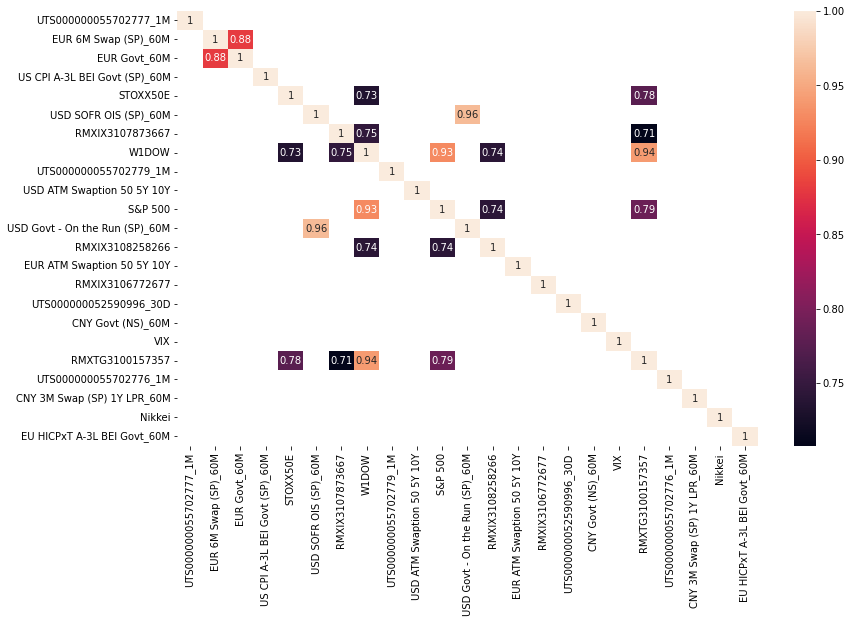

In [294]:
# Check correlation between risk factors
if rem_corr_rf:
    
    df_correlation_rf = compute_ts_correlation(df_complete,
                                                  detrend_strategy='diff',
                                                  res_index=risk_factors_to_include_available,
                                                  res_columns=risk_factors_to_include_available)
    
    fig, ax = plt.subplots(1, 1, figsize=(13, 8))
    seaborn.heatmap(df_correlation_rf[df_correlation_rf>=corr_threshold], annot=True)

    a, b = np.where(abs(df_correlation_rf.values) > corr_threshold)
    rf_high_corr = {}
    for i in range(len(a)):
        rf1 = df_correlation_rf.columns[a[i]]
        rf2 = df_correlation_rf.columns[b[i]]
        if rf1 != rf2:
            if rf1 not in rf_high_corr:
                rf_high_corr[rf1] = [rf2]
            else:
                rf_high_corr[rf1].append(rf2)

    rf_high_corr = dict(sorted(rf_high_corr.items()))

    rf_to_remove = []
    for rf in rf_high_corr:
        if rf not in rf_to_remove:
            rf_to_remove = [*rf_to_remove, *rf_high_corr[rf]]

    print(str(len(set(rf_to_remove))) + ' risk factors removed due to high correlation: ' + str(set(rf_to_remove)))

    risk_factors_to_include_available = list(set(risk_factors_to_include_available).difference(set(rf_to_remove)))

In [296]:
risk_factors_to_include_available = ['UTS000000055702777_1M',
 'EUR ATM Swaption 50 5Y 10Y',
 'RMXIX3106772677',
 'UTS000000052590996_30D',
 'US CPI A-3L BEI Govt (SP)_60M',
 'CNY Govt (NS)_60M',
 'VIX',
 'RMXIX3107873667',
 'UTS000000055702776_1M',
 'CNY 3M Swap (SP) 1Y LPR_60M',
 'Nikkei',
 'UTS000000055702779_1M',
 'USD ATM Swaption 50 5Y 10Y',
 'EU HICPxT A-3L BEI Govt_60M',
 'USD Govt - On the Run (SP)_60M','S&P 500','STOXX50E','EUR Govt_60M']

In [302]:
# Df with dimension num_curves x num_risk_factors_to_include with correlations between all curves and risk factors
# included in the analysis
link_metrics = 'corr'
if link_metrics in ['corr', 'corr_based_dist']:
    
    df_correlation = compute_ts_correlation(df_complete,
                                           detrend_strategy='diff',
                                           res_index=df_all_lookup_filtered.columns,
                                           res_columns=risk_factors_to_include_available,
                                           return_distance=False)
    
else:
    
    df_correlation = varInfoDf(df_complete, detrend_strategy='diff', norm=True,
                               res_index=df_all_lookup_filtered.columns,
                               res_columns=risk_factors_to_include_available)

In [303]:
def getSVD(matrix):
    
    leVec , Sval , reVec = np.linalg.svd(matrix)
    Sval_diag = np.diagflat(Sval)
    Sval_svd = np.vstack((Sval_diag,np.zeros((matrix.shape[0]-matrix.shape[1],matrix.shape[1]))))
    return leVec,Sval_diag,Sval_svd, reVec

In [304]:
matrix = df_correlation.values
q = np.round(matrix.shape[0] / matrix.shape[1])
leVec,Sval,Sval_svd, reVec = getSVD(matrix)
eMax, var = findMaxEval(np.diag(Sval), q, bWidth=0.01)
nFacts = Sval.shape[0]-np.diag(Sval)[::-1].searchsorted(eMax)  

sse:2272.845384838484
sse:2272.8452792590124
sse:828.6972646041054
sse:828.6972961735444
found errPDFs0.99999


In [305]:
def detonedCorr_ext(corr, singular_values, left_eigenvectors, right_eigenvectors, market_component=1):
    """
    De-tones the de-noised correlation matrix by removing the market component.
    The input is the eigenvalues and the eigenvectors of the correlation matrix and the number
    of the first eigenvalue that is above the maximum theoretical eigenvalue and the number of
    eigenvectors related to a market component.
    :param corr: (np.array) Correlation matrix to detone.
    :param eigenvalues: (np.array) Matrix with eigenvalues on the main diagonal.
    :param eigenvectors: (float) Eigenvectors array.
    :param market_component: (int) Number of fist eigevectors related to a market component. (1 by default)
    :return: (np.array) De-toned correlation matrix.
    """
    
    # Getting the eigenvalues and eigenvectors related to market component
    eigenvalues_mark = singular_values[:market_component, :market_component]
    left_eigenvectors_mark = left_eigenvectors[:, :market_component]
    right_eigenvectors_mark = right_eigenvectors[:, :market_component]
    # Calculating the market component correlation
    corr_mark = np.dot(left_eigenvectors_mark, eigenvalues_mark).dot(right_eigenvectors_mark.T)
    
    # Removing the market component from the de-noised correlation matrix
    corr = corr - corr_mark
    
    
    return corr

In [306]:
def denoisedCorr_ext(eVal, leVec, reVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    eVal_svd_denoised = np.vstack((eVal_ ,np.zeros((matrix.shape[0]-matrix.shape[1],matrix.shape[1]))))
    corr1 = np.dot(leVec, eVal_svd_denoised).dot(reVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    #corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1

In [307]:
matrix = df_correlation.values
q = np.round(matrix.shape[0] / matrix.shape[1])
leVec,Sval,Sval_svd, reVec = getSVD(matrix)

In [308]:
eMax, var = findMaxEval(np.diag(Sval), q, bWidth=0.01)

sse:2272.845384838484
sse:2272.8452792590124
sse:828.6972646041054
sse:828.6972961735444
found errPDFs0.99999


In [309]:
matrix = df_correlation.values
q = np.round(matrix.shape[0] / matrix.shape[1])
leVec,Sval,Sval_svd, reVec = getSVD(matrix)
eMax, var = findMaxEval(np.diag(Sval), q, bWidth=0.01)
nFacts = Sval.shape[0]-np.diag(Sval)[::-1].searchsorted(eMax)  
corr_denoised =denoisedCorr_ext(Sval_svd,leVec,reVec,nFacts)

sse:2272.845384838484
sse:2272.8452792590124
sse:828.6972646041054
sse:828.6972961735444
found errPDFs0.99999


In [310]:
leVec,Sval_diag,Sval_svd, reVec = getSVD(corr_denoised)

In [311]:
corr_detoned_denoised = detonedCorr_ext(corr_denoised, Sval_svd, leVec,reVec, market_component=1)

In [312]:
dist_matrix = ((1-corr_detoned_denoised)/2.)**.5

In [314]:
df_distances = pd.DataFrame(dist_matrix,index=df_all_lookup_filtered.columns,columns=risk_factors_to_include_available)

In [334]:
clustering_results, silhouette, inertia = try_k_means_varying_k(df_distances,min_num_clusters=3, max_num_clusters=50, n_init=5)

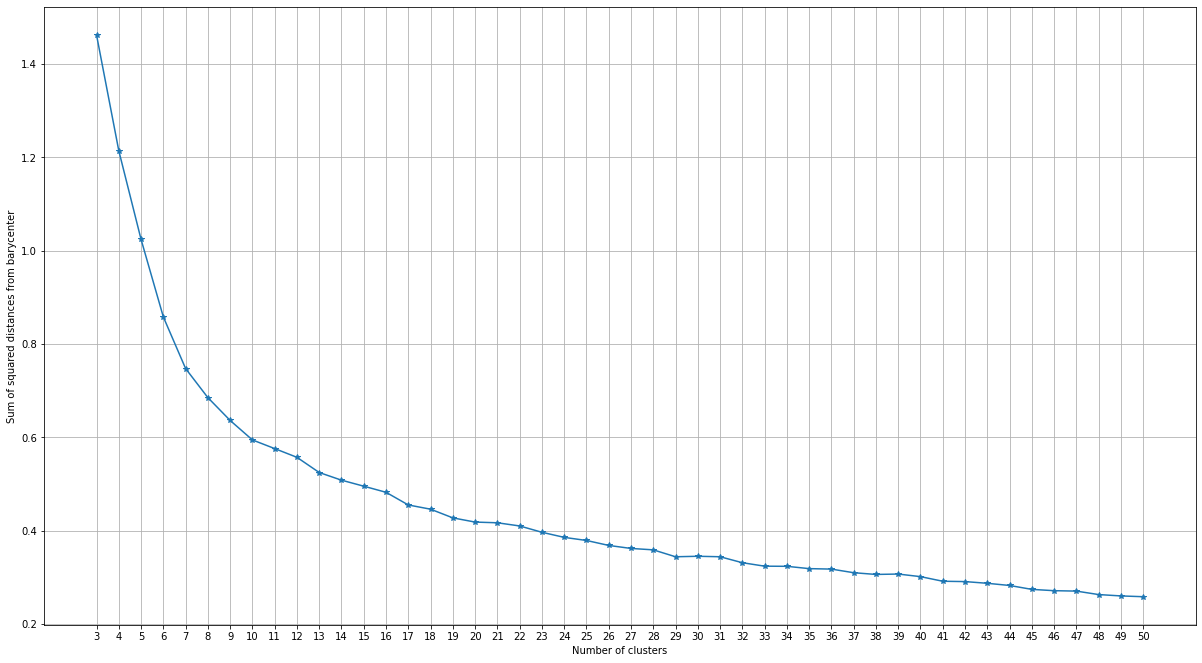

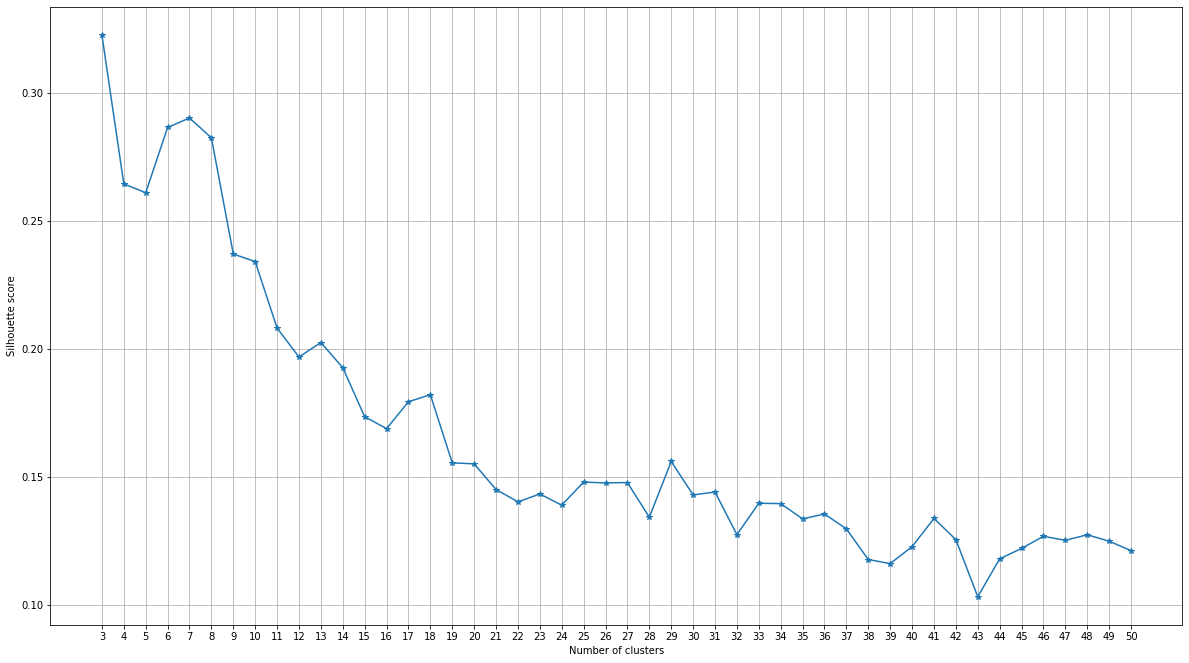

In [335]:
# Elbow plot of inertia
plot_kpi_by_num_clusters(inertia, 'Sum of squared distances from barycenter')
    
# Plot of silhouette score
plot_kpi_by_num_clusters(silhouette, 'Silhouette score')

In [336]:
# Specify number of clusters for which you want to see and save results
num_clusters = 7
km_results = clustering_results[num_clusters]

df_results = df_correlation.assign(cluster_label=km_results)

In [337]:
k= 5
top_factors_per_cluster = {}
for cl in df_results['cluster_label'].unique():

    res_current_cl = df_results[df_results['cluster_label'] == cl].drop(columns='cluster_label')
    avg_corr_factors = {}

    for factor in res_current_cl.columns:
        avg_corr_factors[factor] = np.average(res_current_cl.loc[:, factor])

    top_factors_per_cluster[cl] = {}
    top_factors_per_cluster[cl]['factors'] = list(pd.DataFrame(avg_corr_factors.items(), columns=['rf', 'avg_corr']).\
                                        sort_values(by='avg_corr', ascending=True).\
                                        head(k)[['rf']].sort_values(by='rf')['rf'].unique())
    top_factors_per_cluster[cl]['avg_corr'] = list(pd.DataFrame(avg_corr_factors.items(), columns=['rf', 'avg_corr']).\
                                        loc[lambda x: x['rf'].isin(top_factors_per_cluster[cl]['factors'])].\
                                        sort_values(by='rf')['avg_corr'].unique())

In [338]:
num_pairs = 0
for cl1 in top_factors_per_cluster:
    set_cl1 = set(top_factors_per_cluster[cl1]['factors'])
    for cl2 in top_factors_per_cluster:
        if (set_cl1 == set(top_factors_per_cluster[cl2]['factors'])) and cl1 < cl2:
            print(str(cl1) + ' and ' + str(cl2) + ' have same most important factors')
            num_pairs += 1
print('\n')
print(str(num_pairs) + ' pairs of clusters having same most important risk factors')

4 and 5 have same most important factors
1 and 4 have same most important factors
1 and 5 have same most important factors
1 and 3 have same most important factors
3 and 4 have same most important factors
3 and 5 have same most important factors


6 pairs of clusters having same most important risk factors


Number of clusters for silhouette plot: 7
For n_clusters = 7 The average silhouette_score is : 0.29012994807281706


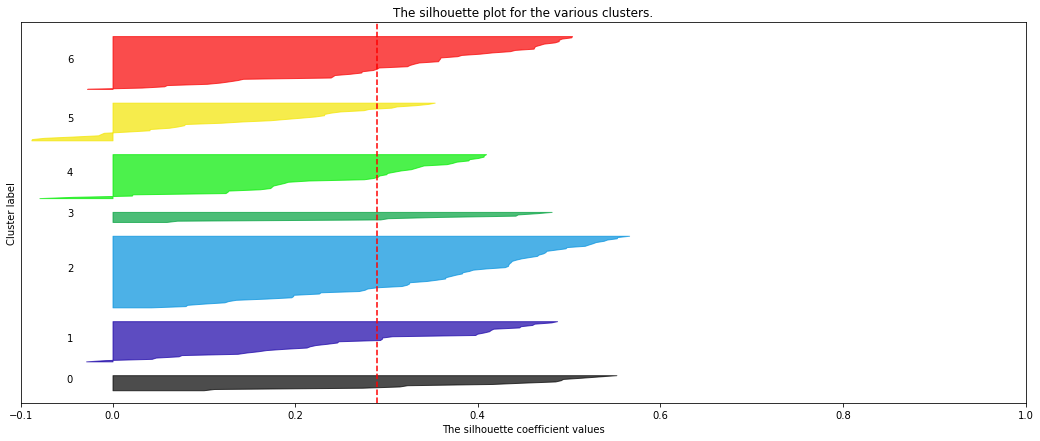

In [339]:
silhouette_plot(df_distances.values, km_results)

In [340]:
# Save output with clustering results
file_name_clustering_results = 'results_rf3_corDist.csv'

df_results = df_correlation.assign(cluster_label=km_results)
df_results = df_results[['cluster_label']]
df_results = pd.DataFrame(df_results).reset_index()
df_results = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    merge(df_results)
df_results['MS_Sector'] = np.where(df_results['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_results['MS_Sector'])
num_clusters = len(df_results['cluster_label'].unique())
df_results['cluster_label'] = np.where(df_results['cluster_label'] == 0,
                                      num_clusters,
                                      df_results['cluster_label'])
df_results.to_csv('Output/4.1-4_Clustering_Results/' + file_name_clustering_results, sep=';', index=False)

In [341]:
num_pairs = 0
for cl1 in top_factors_per_cluster:
    set_cl1 = set(top_factors_per_cluster[cl1]['factors'])
    for cl2 in top_factors_per_cluster:
        if (set_cl1 == set(top_factors_per_cluster[cl2]['factors'])) and cl1 < cl2:
            print(str(cl1) + ' and ' + str(cl2) + ' have same most important factors')
            num_pairs += 1
print('\n')
print(str(num_pairs) + ' pairs of clusters having same most important risk factors')

4 and 5 have same most important factors
1 and 4 have same most important factors
1 and 5 have same most important factors
1 and 3 have same most important factors
3 and 4 have same most important factors
3 and 5 have same most important factors


6 pairs of clusters having same most important risk factors


In [342]:
# Save output with most relevant risk factors per each cluster
file_name_important_rf = 'results_top_rf_rf3_corDist.csv'

df_top_rf_result = pd.DataFrame()
for cl in top_factors_per_cluster:
    temp_df = pd.DataFrame(top_factors_per_cluster[cl]).assign(cluster_label = cl)
    df_top_rf_result = pd.concat([df_top_rf_result, temp_df], ignore_index=True)

num_clusters = len(df_top_rf_result['cluster_label'].unique())
df_top_rf_result['cluster_label'] = np.where(df_top_rf_result['cluster_label'] == 0,
                                              num_clusters,
                                              df_top_rf_result['cluster_label'])
df_top_rf_result.to_csv('Output/4.1-4_Clustering_Results/' + file_name_important_rf, sep=';', index=False)

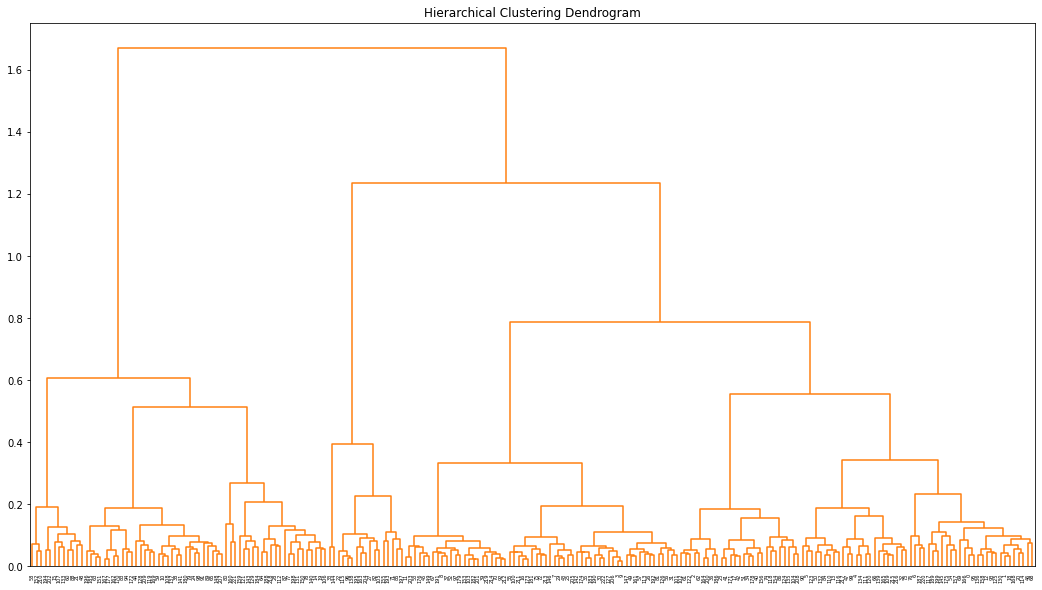

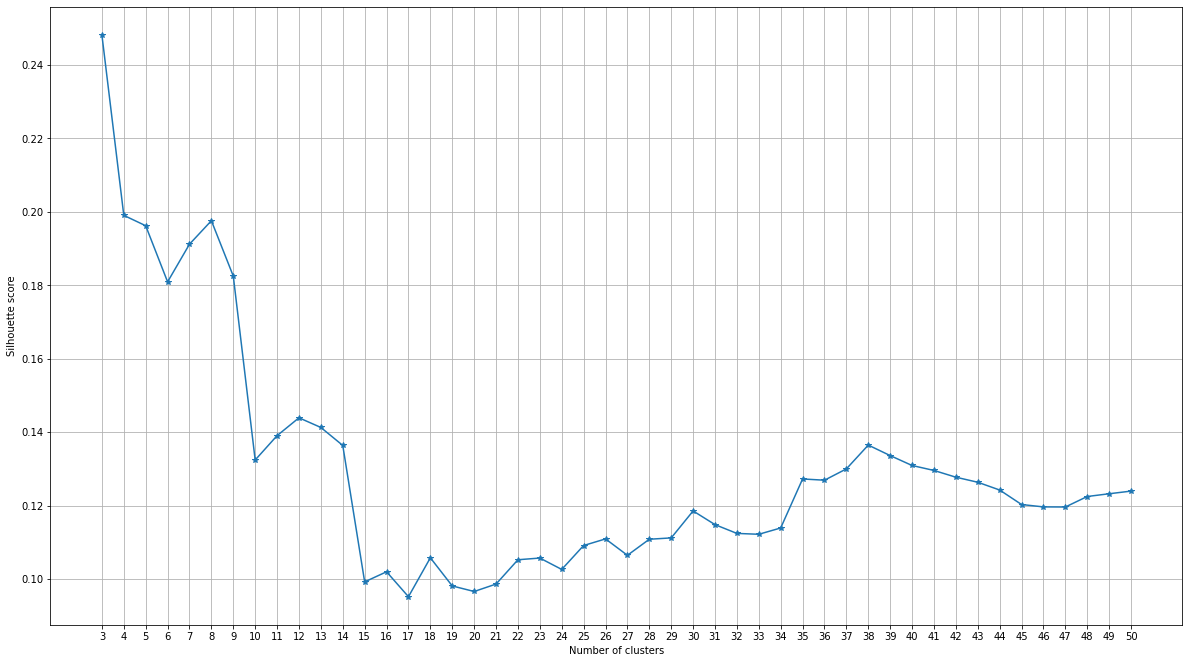

In [343]:
hier_clus_linkage = 'ward'
# Max number of clusters
max_num_clusters = 50

hier_clust_fit, linkage = hierarchical_clustering_and_dendrogram(df_distances,
                                                                    linkage_hierarchical_clustering=hier_clus_linkage)
    
# Find clustering results for different values of number of clusters from dendrogram
clustering_results = {}
for i in range(3, max_num_clusters+1):
    clusters = fcluster(linkage, t=i, criterion='maxclust')
    clustering_results[i] = clusters
        
# Silhouette scores for the different numbers of clusters
silhouette_scores = {}
for i in clustering_results:
    sil_score = silhouette_score(df_correlation, clustering_results[i], metric='euclidean')
    silhouette_scores[i] = sil_score
        
# Plot of silhouette score
plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

In [344]:
# Specify number of clusters for which you want to see and save results
num_clusters = 8
km_results = clustering_results[num_clusters]

df_results = df_correlation.assign(cluster_label=km_results)

Number of clusters for silhouette plot: 8
For n_clusters = 8 The average silhouette_score is : 0.2548121068419749


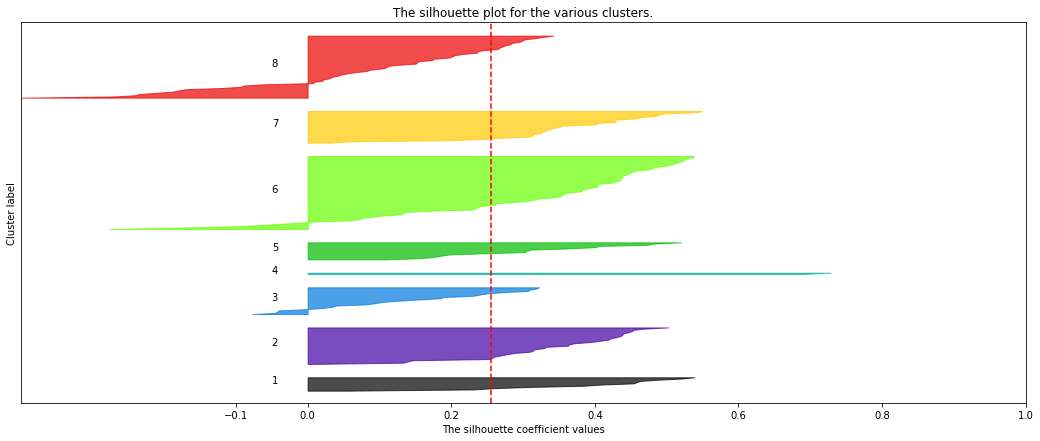

In [345]:
silhouette_plot(df_distances.values, km_results)

In [346]:
k= 5
top_factors_per_cluster = {}
for cl in df_results['cluster_label'].unique():

    res_current_cl = df_results[df_results['cluster_label'] == cl].drop(columns='cluster_label')
    avg_corr_factors = {}

    for factor in res_current_cl.columns:
        avg_corr_factors[factor] = np.average(res_current_cl.loc[:, factor])

    top_factors_per_cluster[cl] = {}
    top_factors_per_cluster[cl]['factors'] = list(pd.DataFrame(avg_corr_factors.items(), columns=['rf', 'avg_corr']).\
                                        sort_values(by='avg_corr', ascending=True).\
                                        head(k)[['rf']].sort_values(by='rf')['rf'].unique())
    top_factors_per_cluster[cl]['avg_corr'] = list(pd.DataFrame(avg_corr_factors.items(), columns=['rf', 'avg_corr']).\
                                        loc[lambda x: x['rf'].isin(top_factors_per_cluster[cl]['factors'])].\
                                        sort_values(by='rf')['avg_corr'].unique())

In [347]:
num_pairs = 0
for cl1 in top_factors_per_cluster:
    set_cl1 = set(top_factors_per_cluster[cl1]['factors'])
    for cl2 in top_factors_per_cluster:
        if (set_cl1 == set(top_factors_per_cluster[cl2]['factors'])) and cl1 < cl2:
            print(str(cl1) + ' and ' + str(cl2) + ' have same most important factors')
            num_pairs += 1
print('\n')
print(str(num_pairs) + ' pairs of clusters having same most important risk factors')

6 and 7 have same most important factors
3 and 8 have same most important factors
3 and 5 have same most important factors
5 and 8 have same most important factors


4 pairs of clusters having same most important risk factors


In [348]:
# Save output with clustering results
file_name_clustering_results = 'results_rf4_corDist.csv'

df_results = df_correlation.assign(cluster_label=km_results)
df_results = df_results[['cluster_label']]
df_results = pd.DataFrame(df_results).reset_index()
df_results = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    merge(df_results)
df_results['MS_Sector'] = np.where(df_results['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_results['MS_Sector'])
num_clusters = len(df_results['cluster_label'].unique())
df_results['cluster_label'] = np.where(df_results['cluster_label'] == 0,
                                      num_clusters,
                                      df_results['cluster_label'])
df_results.to_csv('Output/4.1-4_Clustering_Results/' + file_name_clustering_results, sep=';', index=False)

In [349]:
# Save output with most relevant risk factors per each cluster
file_name_important_rf = 'results_top_rf_rf4_corDist.csv'

df_top_rf_result = pd.DataFrame()
for cl in top_factors_per_cluster:
    temp_df = pd.DataFrame(top_factors_per_cluster[cl]).assign(cluster_label = cl)
    df_top_rf_result = pd.concat([df_top_rf_result, temp_df], ignore_index=True)

num_clusters = len(df_top_rf_result['cluster_label'].unique())
df_top_rf_result['cluster_label'] = np.where(df_top_rf_result['cluster_label'] == 0,
                                              num_clusters,
                                              df_top_rf_result['cluster_label'])
df_top_rf_result.to_csv('Output/4.1-4_Clustering_Results/' + file_name_important_rf, sep=';', index=False)

In [352]:
# Experiments Variation of Information


In [353]:
df_correlation_vi = varInfoDf(df_complete, detrend_strategy='diff', norm=True,
                               res_index=df_all_lookup_filtered.columns,
                               res_columns=risk_factors_to_include_available)

In [354]:
matrix = df_correlation_vi.values
q = np.round(matrix.shape[0] / matrix.shape[1])
leVec,Sval,Sval_svd, reVec = getSVD(matrix)
eMax, var = findMaxEval(np.diag(Sval), q, bWidth=0.01)
nFacts = Sval.shape[0]-np.diag(Sval)[::-1].searchsorted(eMax)  
vi_denoised =denoisedCorr_ext(Sval_svd,leVec,reVec,nFacts)

sse:1969.3607143650836
sse:1969.3606452481656
sse:816.1678390306598
sse:816.1678680461098
found errPDFs0.99999


In [355]:
leVec,Sval_diag,Sval_svd, reVec = getSVD(vi_denoised)

In [356]:
vi_detoned_denoised = detonedCorr_ext(vi_denoised, Sval_svd, leVec,reVec, market_component=1)

In [357]:
clustering_results, silhouette, inertia = try_k_means_varying_k(vi_detoned_denoised,min_num_clusters=3, max_num_clusters=50, n_init=5)

In [358]:
# Elbow plot of inertia
plot_kpi_by_num_clusters(inertia, 'Sum of squared distances from barycenter')
    
# Plot of silhouette score
plot_kpi_by_num_clusters(silhouette, 'Silhouette score')

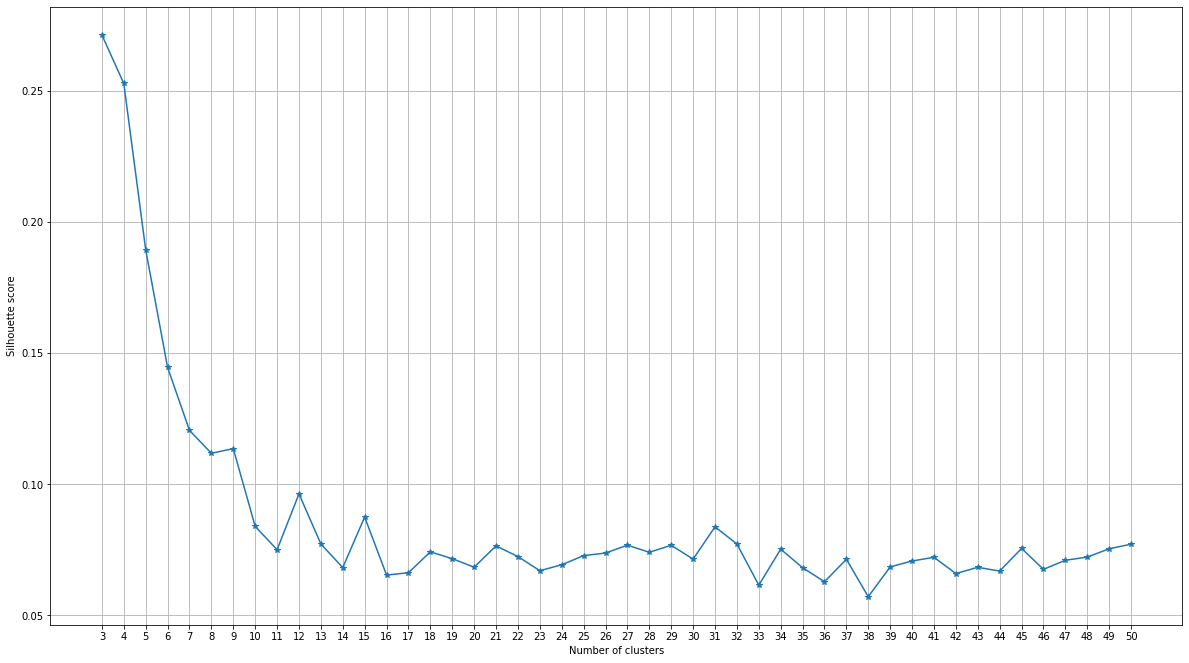

In [360]:
# Elbow plot of inertia
plot_kpi_by_num_clusters(inertia, 'Sum of squared distances from barycenter')
    
# Plot of silhouette score
plot_kpi_by_num_clusters(silhouette, 'Silhouette score')
# Specify number of clusters for which you want to see and save results
num_clusters = 7
km_results = clustering_results[num_clusters]

df_results = df_correlation.assign(cluster_label=km_results)

In [362]:
# Save output with clustering results
file_name_clustering_results = 'results_rf5_corDist.csv'

df_results = df_correlation.assign(cluster_label=km_results)
df_results = df_results[['cluster_label']]
df_results = pd.DataFrame(df_results).reset_index()
df_results = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    merge(df_results)
df_results['MS_Sector'] = np.where(df_results['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_results['MS_Sector'])
num_clusters = len(df_results['cluster_label'].unique())
df_results['cluster_label'] = np.where(df_results['cluster_label'] == 0,
                                      num_clusters,
                                      df_results['cluster_label'])
df_results.to_csv('Output/4.1-4_Clustering_Results/' + file_name_clustering_results, sep=';', index=False)

In [363]:
# Save output with most relevant risk factors per each cluster
file_name_important_rf = 'results_top_rf_rf5_corDist.csv'

df_top_rf_result = pd.DataFrame()
for cl in top_factors_per_cluster:
    temp_df = pd.DataFrame(top_factors_per_cluster[cl]).assign(cluster_label = cl)
    df_top_rf_result = pd.concat([df_top_rf_result, temp_df], ignore_index=True)

num_clusters = len(df_top_rf_result['cluster_label'].unique())
df_top_rf_result['cluster_label'] = np.where(df_top_rf_result['cluster_label'] == 0,
                                              num_clusters,
                                              df_top_rf_result['cluster_label'])
df_top_rf_result.to_csv('Output/4.1-4_Clustering_Results/' + file_name_important_rf, sep=';', index=False)

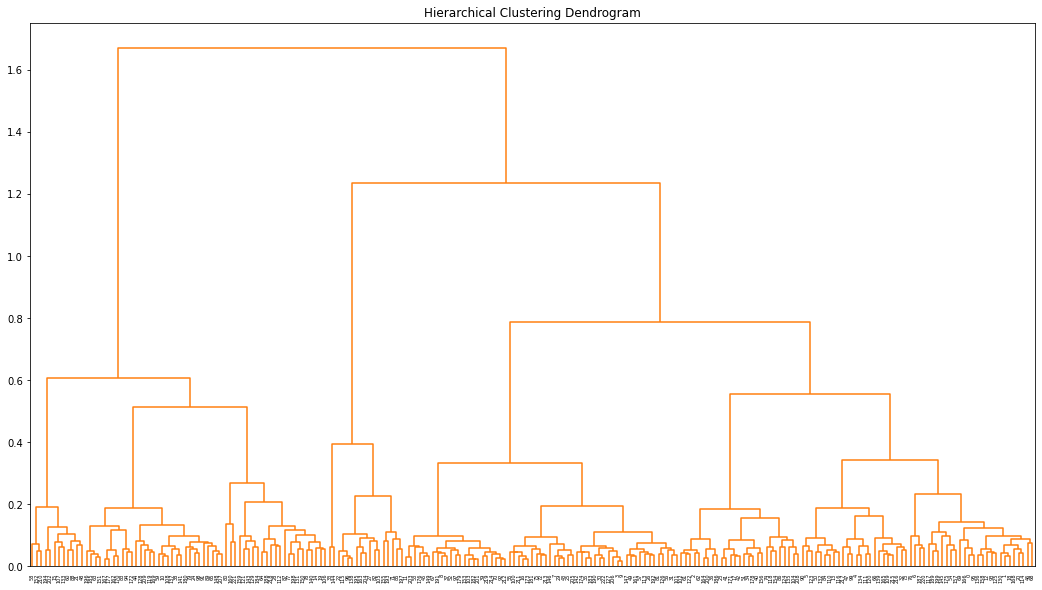

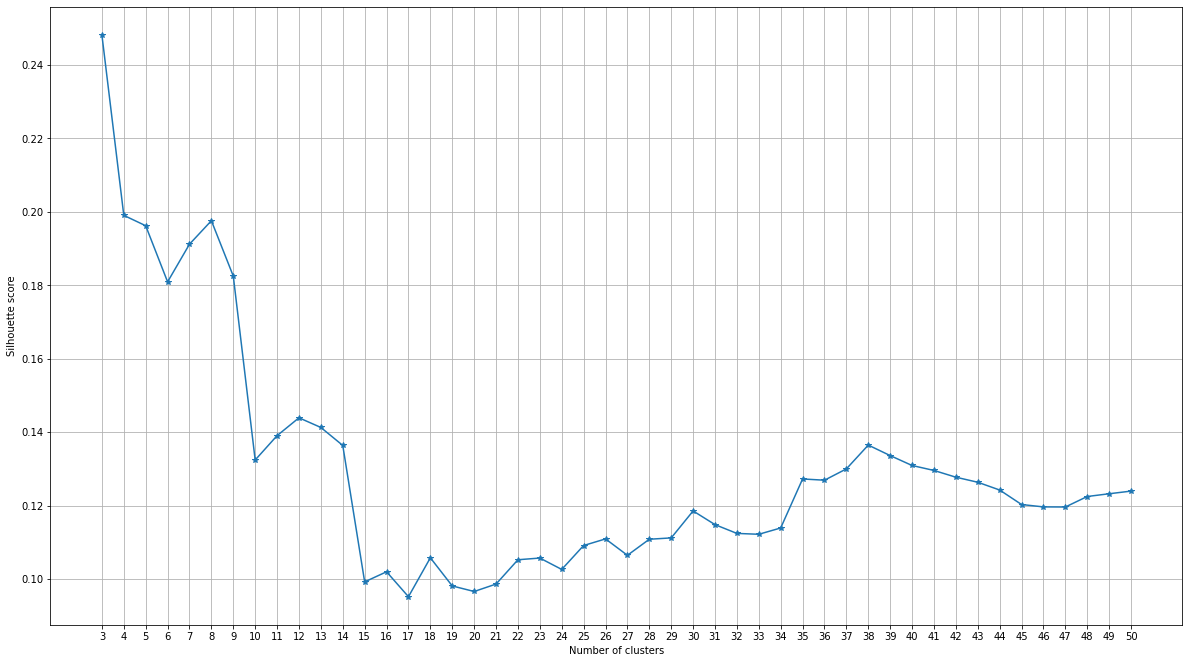

In [364]:
hier_clus_linkage = 'ward'
# Max number of clusters
max_num_clusters = 50

hier_clust_fit, linkage = hierarchical_clustering_and_dendrogram(df_distances,
                                                                    linkage_hierarchical_clustering=hier_clus_linkage)
    
# Find clustering results for different values of number of clusters from dendrogram
clustering_results = {}
for i in range(3, max_num_clusters+1):
    clusters = fcluster(linkage, t=i, criterion='maxclust')
    clustering_results[i] = clusters
        
# Silhouette scores for the different numbers of clusters
silhouette_scores = {}
for i in clustering_results:
    sil_score = silhouette_score(df_correlation, clustering_results[i], metric='euclidean')
    silhouette_scores[i] = sil_score
        
# Plot of silhouette score
plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

In [365]:
# Specify number of clusters for which you want to see and save results
num_clusters = 8
km_results = clustering_results[num_clusters]

df_results = df_correlation.assign(cluster_label=km_results)

In [366]:
k= 5
top_factors_per_cluster = {}
for cl in df_results['cluster_label'].unique():

    res_current_cl = df_results[df_results['cluster_label'] == cl].drop(columns='cluster_label')
    avg_corr_factors = {}

    for factor in res_current_cl.columns:
        avg_corr_factors[factor] = np.average(res_current_cl.loc[:, factor])

    top_factors_per_cluster[cl] = {}
    top_factors_per_cluster[cl]['factors'] = list(pd.DataFrame(avg_corr_factors.items(), columns=['rf', 'avg_corr']).\
                                        sort_values(by='avg_corr', ascending=True).\
                                        head(k)[['rf']].sort_values(by='rf')['rf'].unique())
    top_factors_per_cluster[cl]['avg_corr'] = list(pd.DataFrame(avg_corr_factors.items(), columns=['rf', 'avg_corr']).\
                                        loc[lambda x: x['rf'].isin(top_factors_per_cluster[cl]['factors'])].\
                                        sort_values(by='rf')['avg_corr'].unique())

In [367]:
# Save output with clustering results
file_name_clustering_results = 'results_rf6_corDist.csv'

df_results = df_correlation.assign(cluster_label=km_results)
df_results = df_results[['cluster_label']]
df_results = pd.DataFrame(df_results).reset_index()
df_results = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    merge(df_results)
df_results['MS_Sector'] = np.where(df_results['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_results['MS_Sector'])
num_clusters = len(df_results['cluster_label'].unique())
df_results['cluster_label'] = np.where(df_results['cluster_label'] == 0,
                                      num_clusters,
                                      df_results['cluster_label'])
df_results.to_csv('Output/4.1-4_Clustering_Results/' + file_name_clustering_results, sep=';', index=False)

# Save output with most relevant risk factors per each cluster
file_name_important_rf = 'results_top_rf_rf6_corDist.csv'

df_top_rf_result = pd.DataFrame()
for cl in top_factors_per_cluster:
    temp_df = pd.DataFrame(top_factors_per_cluster[cl]).assign(cluster_label = cl)
    df_top_rf_result = pd.concat([df_top_rf_result, temp_df], ignore_index=True)

num_clusters = len(df_top_rf_result['cluster_label'].unique())
df_top_rf_result['cluster_label'] = np.where(df_top_rf_result['cluster_label'] == 0,
                                              num_clusters,
                                              df_top_rf_result['cluster_label'])
df_top_rf_result.to_csv('Output/4.1-4_Clustering_Results/' + file_name_important_rf, sep=';', index=False)